# Financial Analyst Agent for Annual Report Writing

In this demo, we introduce an agent that can analyze financial report.

In [1]:
import os
import autogen
from autogen.cache import Cache

from finrobot.utils import register_keys_from_json
from finrobot.toolkits import register_toolkits
from finrobot.functional import (
    ReportChartUtils,
    ReportAnalysisUtils,
    IPythonUtils,
    ReportLabUtils,
    TextUtils,
)
from finrobot.data_source import FMPUtils
from textwrap import dedent


os.environ["FMP_API_KEY"] = "fmp_api"
os.environ["OPENAI_API_KEY"] = "openai_api"
os.environ["SEC_API_KEY"] = "sec_api"
work_dir = r"c:/Users/wujie/Downloads/FinRobot-master/tutorials_advanced/report"
os.makedirs(work_dir, exist_ok=True)


C:\Users\wujie\anaconda3\envs\finrobot\lib\site-packages\flaml\__init__.py:20: UserWarning: flaml.automl is not available. Please install flaml[automl] to enable AutoML functionalities.
  warnings.warn("flaml.automl is not available. Please install flaml[automl] to enable AutoML functionalities.")


FMP key ok: Hdbw2F78 ...
OpenAI key ok: sk-proj- ...
SEC key ok: 5e0fb440 ...
work_dir: c:/Users/wujie/Downloads/FinRobot-master/tutorials_advanced/report


After importing all the necessary packages and functions, we also need the config for OpenAI & SecApi & FMPApi here.
- for openai configuration, rename OAI_CONFIG_LIST_sample to OAI_CONFIG_LIST and replace the api keys
- for Sec_api & FMP_api configuration, rename config_api_keys_sample to config_api_keys and replace the api keys

In [2]:
import os

config_list = [{
    "model": "gpt-4.1",
    "api_key": os.environ["OPENAI_API_KEY"],
    "base_url": "https://api.openai.com/v1",
}]
llm_config = {
    "config_list": config_list,
    "timeout": 120,
    # "temperature": 0 # for debug convenience
    "temperature": 0.5,
    "max_tokens": 800, 
}


For this task, we need:
- A user proxy to execute python functions and control the conversations.
- An expert agent who is proficient in financial analytical writing.
- A shadow/inner-assistant to handle isolated long-context Q&As. (Because we dont want to keep the sec files in the chat history.)
In the following cell, we define the agents, and equip them with necessary tools.

In [3]:
system_message = dedent(
    f"""
    Role: Expert Investor
    Department: Finance
    Primary Responsibility: Generation of Customized Financial Analysis Reports

    Role Description:
    As an Expert Investor within the finance domain, your expertise is harnessed to develop bespoke Financial Analysis Reports that cater to specific client requirements. This role demands a deep dive into financial statements and market data to unearth insights regarding a company's financial performance and stability. Engaging directly with clients to gather essential information and continuously refining the report with their feedback ensures the final product precisely meets their needs and expectations.

    Key Objectives:

    Analytical Precision: Employ meticulous analytical prowess to interpret financial data, identifying underlying trends and anomalies.
    Effective Communication: Simplify and effectively convey complex financial narratives, making them accessible and actionable to non-specialist audiences.
    Client Focus: Dynamically tailor reports in response to client feedback, ensuring the final analysis aligns with their strategic objectives.
    Adherence to Excellence: Maintain the highest standards of quality and integrity in report generation, following established benchmarks for analytical rigor.
    Performance Indicators:
    The efficacy of the Financial Analysis Report is measured by its utility in providing clear, actionable insights. This encompasses aiding corporate decision-making, pinpointing areas for operational enhancement, and offering a lucid evaluation of the company's financial health. Success is ultimately reflected in the report's contribution to informed investment decisions and strategic planning.

    Reply TERMINATE when everything is settled.
    """
)
expert = autogen.AssistantAgent(
    name="Expert_Investor",
    system_message=system_message,
    llm_config=llm_config,
    is_termination_msg=lambda x: x.get("content", "")
    and x.get("content", "").endswith("TERMINATE"),
)
expert_shadow = autogen.AssistantAgent(
    name="Expert_Investor_Shadow",
    system_message=system_message,
    llm_config=llm_config,
)

user_proxy = autogen.UserProxyAgent(
    name="User_Proxy",
    human_input_mode="NEVER",
    is_termination_msg=lambda x: x.get("content","")
    and x.get("content","").endswith("TERMINATE"),
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": work_dir,
        "use_docker": False,
    },
)


[autogen.oai.client: 02-20 15:11:21] {164} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.
[autogen.oai.client: 02-20 15:11:21] {164} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.


In [4]:
register_toolkits(
    [
        FMPUtils.get_sec_report,  # Retrieve SEC report url and filing date
        IPythonUtils.display_image,  # Display image in IPython
        TextUtils.check_text_length,  # Check text length
        ReportLabUtils.build_annual_report,  # Build annual report in designed pdf format
        ReportAnalysisUtils,  # Expert Knowledge for Report Analysis
        ReportChartUtils,  # Expert Knowledge for Report Chart Plotting
    ],
    expert,
    user_proxy,
)

[autogen.oai.client: 02-20 15:11:23] {164} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.
[autogen.oai.client: 02-20 15:11:23] {164} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.
[autogen.oai.client: 02-20 15:11:23] {164} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.
[autogen.oai.client: 02-20 15:11:23] {164} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.
[autogen.oai.client: 02-20 15:11:23] {164} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.
[autogen.oai.client: 02-20 15:11:23] {164} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.
[autogen.oai.client: 02-20 15:11:23] {164} WARNING - The API key specified is not a valid OpenAI format; i

In this section, we introduce the **nested chat between the expert and the shadow**, which is triggered only when the expert gets response from function execution showing that an writing instruction and related context & resources are ready. The writing would then happen in this separate chat, the shadow (or call it the inner mind of expert) would do the financial writing based on the instruction and turn back to the expert. However, this chat is muted due to long context.

In [5]:
def order_trigger(sender):
    # Check if the last message contains the path to the instruction text file
    return "instruction & resources saved to" in sender.last_message()["content"]


def order_message(recipient, messages, sender, config):
    # Extract the path to the instruction text file from the last message
    full_order = recipient.chat_messages_for_summary(sender)[-1]["content"]
    txt_path = full_order.replace("instruction & resources saved to ", "").strip()
    txt_path = txt_path.splitlines()[0].strip()
    with open(txt_path, "r") as f:
        instruction = f.read() + "\n\nReply TERMINATE at the end of your response."
    return instruction


# Since 10-K section is not short, we need an extra nested chat to analyze the contents
expert.register_nested_chats(
    [
        {
            "sender": expert,
            "recipient": expert_shadow,
            "message": order_message,
            "summary_method": "last_msg",
            "max_turns": 2,
            "silent": True,  # mute the chat summary
        }
    ],
    trigger=order_trigger,
)

### Resources to understand the financial report
1. income statement: https://online.hbs.edu/blog/post/income-statement-analysis
2. balance sheet: https://online.hbs.edu/blog/post/how-to-read-a-balance-sheet
3. cash flow statement: https://online.hbs.edu/blog/post/how-to-read-a-cash-flow-statement
4. Annual report: https://online.hbs.edu/blog/post/how-to-read-an-annual-report

An annual report typically consists of:
1. Letters to shareholders: These documents provide a broad overview of the company’s activities and performance over the course of the year, as well as a reflection on its general business environment. An annual report usually includes a shareholder letter from the CEO or president, and may also contain letters from other key figures, such as the CFO.
2. [section 7] Management’s discussion and analysis (MD&A): This is a detailed analysis of the company’s performance, as conducted by its executives.
3. [section 8] Audited financial statements: These are financial documents that detail the company’s financial performance. Commonly included statements include balance sheets, cash flow statements, income statements, and equity statements.
4. [section 8] A summary of financial data: This refers to any notes or discussions that are pertinent to the financial statements listed above.
5. [section 8] Auditor’s report: This report describes whether the company has complied with generally accepted accounting principles (GAAP) in preparing its financial statements.
6. Accounting policies: This is an overview of the policies the company’s leadership team relied upon in preparing the annual report and financial statements.


Answer the following questions:
1. Whether it’s able to pay debts as they come due
2. Its profits and/or losses year over year
3. If and how it’s grown over time
4. What it requires to maintain or expand its business
5. Operational expenses compared to generated revenues

---

Now, let's see how our agent does.



User_Proxy (to Expert_Investor):


With the tools you've been provided, write an annual report based on QCOM's and ['TXN', 'AVGO', 'TXN', 'AMD', 'NVDA']' 2024 10-k report, and format it into a PDF.

Hard constraints to avoid rate-limit issues:
- Minimize iterations: produce the long-form text in ONE pass.
- Then report word counts for each paragraph in ONE compact line per paragraph.
- Only revise ONCE if a paragraph is out of bounds.

Tool-call rules:
- STRICT JSON only. No literal newlines in JSON strings; use "\n".
- Escape quotes as "\"".
- Keep each string field under 900 characters in tool-call arguments by shortening.

PDF step (must be followed exactly):
1) Generate and save the two images into "c:/Users/wujie/Downloads/FinRobot-master/tutorials_advanced/report" with filenames:
   - amd_share_performance.png
   - amd_pe_eps_performance.png
2) Verify they exist on disk (file-existence check).
3) Call build_annual_report with:
   - ticker_symbol="QCOM"
   - save_path="c:/Users/wu

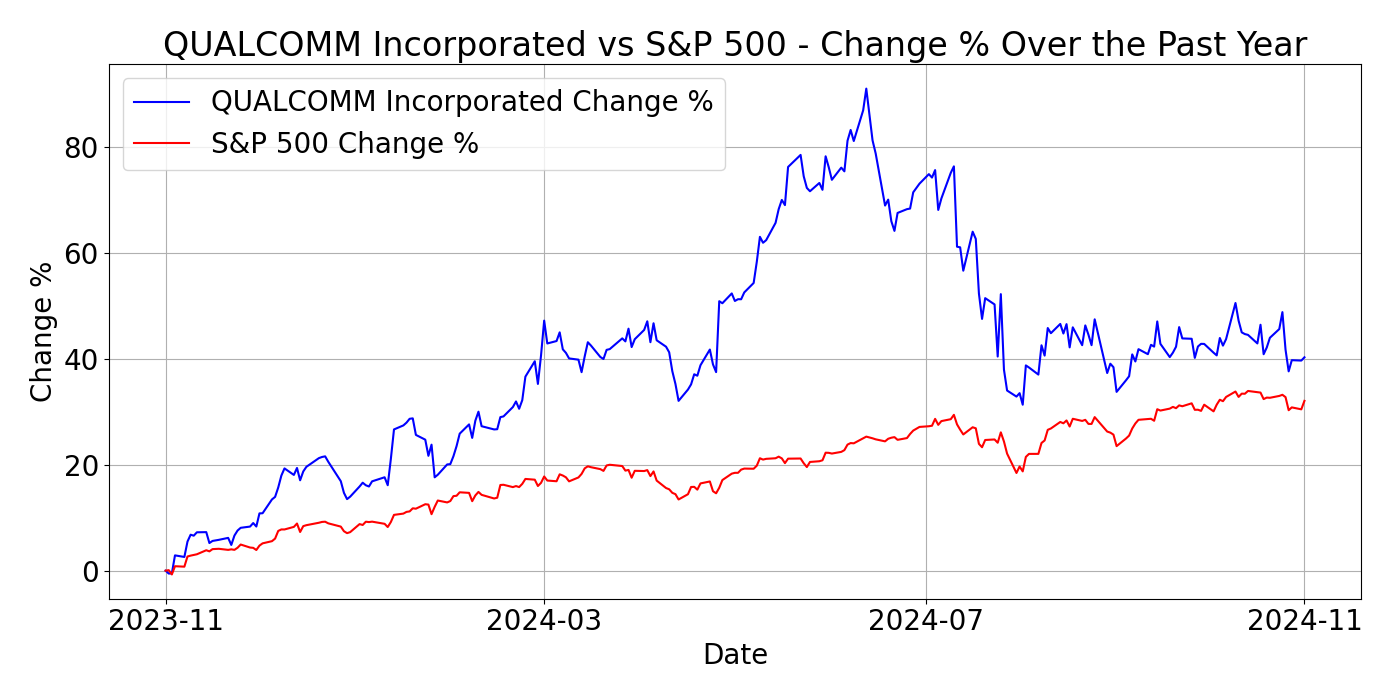

User_Proxy (to Expert_Investor):

User_Proxy (to Expert_Investor):

***** Response from calling tool (call_NcJtHWl7x09wfrUPmzBLDbkz) *****
None
**********************************************************************

--------------------------------------------------------------------------------
[autogen.oai.client: 02-20 15:20:48] {329} WARNING - Model gpt-4.1-2025-04-14 is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
Expert_Investor (to User_Proxy):

***** Suggested tool call (call_PgS4dtufSv6c3i9oYVFRBeWi): display_image *****
Arguments: 
{"image_path":"c:/Users/wujie/Downloads/FinRobot-master/tutorials_advanced/report/amd_pe_eps_performance.png"}
******************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION display_image...


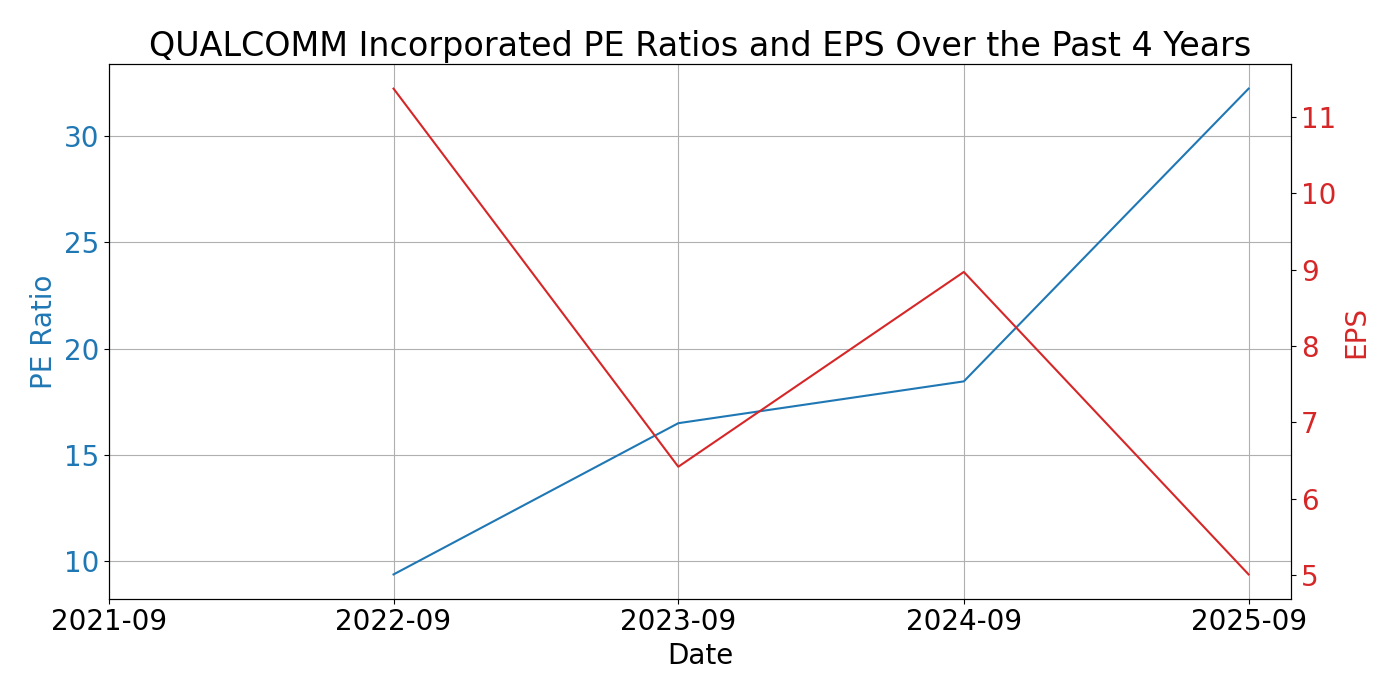

User_Proxy (to Expert_Investor):

User_Proxy (to Expert_Investor):

***** Response from calling tool (call_PgS4dtufSv6c3i9oYVFRBeWi) *****
None
**********************************************************************

--------------------------------------------------------------------------------
[autogen.oai.client: 02-20 15:20:58] {329} WARNING - Model gpt-4.1-2025-04-14 is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
Expert_Investor (to User_Proxy):

***** Suggested tool call (call_JZwPjrt39T56509Z1vWnfRps): build_annual_report *****
Arguments: 
{"share_performance_image_path":"c:/Users/wujie/Downloads/FinRobot-master/tutorials_advanced/report/amd_share_performance.png","pe_eps_performance_image_path":"c:/Users/wujie/Downloads/FinRobot-master/tutorials_advanced/report/amd_pe_eps_performance.png","ticker_symbol":"QCOM","save_path":"c:/Users/wujie/Downloads/FinRobot-master/tutorial

In [11]:
company = "QCOM"
competitors = ["TXN","AVGO","TXN","AMD","NVDA"]   
fyear = "2024"
work_dir = r"c:/Users/wujie/Downloads/FinRobot-master/tutorials_advanced/report"
os.makedirs(work_dir, exist_ok=True)



task = dedent(f"""
With the tools you've been provided, write an annual report based on {company}'s and {competitors}' {fyear} 10-k report, and format it into a PDF.

Hard constraints to avoid rate-limit issues:
- Minimize iterations: produce the long-form text in ONE pass.
- Then report word counts for each paragraph in ONE compact line per paragraph.
- Only revise ONCE if a paragraph is out of bounds.

Tool-call rules:
- STRICT JSON only. No literal newlines in JSON strings; use "\\n".
- Escape quotes as "\\"".
- Keep each string field under 900 characters in tool-call arguments by shortening.

PDF step (must be followed exactly):
1) Generate and save the two images into "{work_dir}" with filenames:
   - amd_share_performance.png
   - amd_pe_eps_performance.png
2) Verify they exist on disk (file-existence check).
3) Call build_annual_report with:
   - ticker_symbol="{company}"
   - save_path="{work_dir}/{company.lower()}_2024_annual_report.pdf"
   - share_performance_image_path and pe_eps_performance_image_path (put these two fields FIRST in the JSON)
   - plus shortened (JSON-safe) text fields.

Content constraints for the draft in chat:
- Page 1: each paragraph 150–160 words.
- Page 2: each paragraph 500–600 words.
""")
with Cache.disk() as cache:
    user_proxy.initiate_chat(
        recipient=expert,
        message=task,
        clear_history=True,
        max_turns=60,
        summary_method="last_msg" ,
    )

In [ ]:
import os
from pathlib import Path
from datetime import datetime

work_dir = Path(r"D:\STAT-GR5398-Spring-2026\FinRobot-Equity-Research-Group\Assignment1\source_code\report\googl")

for f in sorted(work_dir.iterdir()):
    if f.is_file():
        mtime = datetime.fromtimestamp(f.stat().st_mtime)
        print(f"{f.name:40s}  {mtime}")


The Rest Cells are optional, simply used to show the generated PDF

In [ ]:
pip install reportlab

In [ ]:
!pip install PyMuPDF

In [ ]:
import io
import fitz
from PIL import Image


pdf = fitz.open("/content/FinRobot/report/NextEra_Annual_Report_2024.pdf")
page = pdf.load_page(0)
pix = page.get_pixmap()

# Convert the Pixmap to a PIL Image
img = Image.open(io.BytesIO(pix.tobytes("png")))
display(img)